# RAG Explore: Interaktives Experimentieren mit Retrieval-Augmented Generation

In diesem Notebook kannst du alle wichtigen Parameter einer RAG-Pipeline mit LangChain selbst anpassen und die Auswirkungen direkt beobachten.

**Was kannst du hier explorieren?**
- Chunkgröße & Overlap
- Prompt-Formulierung
- Anzahl der Top-k Chunks für das Retrieval

**Ziel:**
Verstehe, wie sich die Parameter auf die Qualität der Antworten und die Auswahl der Chunks auswirken. Probiere verschiedene Kombinationen aus und diskutiere die Ergebnisse!

---


In [18]:
# !pip install langchain langchain_community langchain_openai openai pypdf python-dotenv

In [2]:
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import textwrap

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
import chromadb

# API-Key aus .env laden
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")


## 1. PDFs einlesen

Hier werden die vier Lieferantenberichte geladen und als Dokumente (je Seite) gespeichert.

In [3]:
pdf_dir = "data/PDFs"
all_docs = []

for fn in os.listdir(pdf_dir):
    if not fn.endswith(".pdf"): continue
    loader = PyPDFLoader(os.path.join(pdf_dir, fn))
    docs = loader.load()
    supplier_name = fn.replace(".pdf", "")
    for d in docs:
        d.metadata["source_file"] = fn
        d.metadata["supplier"] = supplier_name
    all_docs.extend(docs)

print(f"{len(all_docs)} Seiten aus PDF-Dateien geladen.")


17 Seiten aus PDF-Dateien geladen.


## 2. Chunking – **Experimentier-Bereich!**

Ändere hier Chunkgröße und Overlap und sieh, wie sich die Chunks ändern!

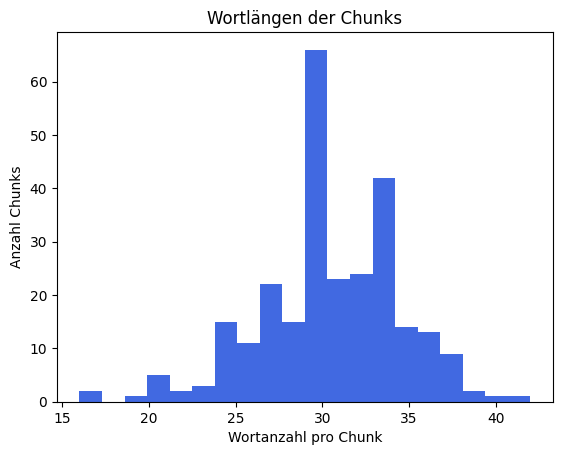

271 Chunks (Größe: 300, Overlap: 100)


In [4]:
# <<< Hier Chunkgröße/Overlap anpassen >>>
chunk_size = 300      # z.B. 500, 800, 1200
chunk_overlap = 100   # z.B. 50, 100, 200

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["\n\n", "\n", ".", "!", "?", " ", ""]
)
split_docs = text_splitter.split_documents(all_docs)

chunk_lens = [len(d.page_content.split()) for d in split_docs]
plt.hist(chunk_lens, bins=20, color='royalblue')
plt.title("Wortlängen der Chunks")
plt.xlabel("Wortanzahl pro Chunk")
plt.ylabel("Anzahl Chunks")
plt.show()

print(f"{len(split_docs)} Chunks (Größe: {chunk_size}, Overlap: {chunk_overlap})")


## 3. Embeddings und Vektorstore (Chroma)

Wandle die Chunks in Embeddings um und speichere sie im Vektorstore.

In [5]:
embeddings = OpenAIEmbeddings()
client = chromadb.PersistentClient(path="db/")
if "chunks" in [c.name for c in client.list_collections()]:
    client.delete_collection("chunks")

vectordb = Chroma(client=client, collection_name="chunks",
                   embedding_function=embeddings)
vectordb.add_documents(split_docs)
print("✅ Vektorstore erstellt (Duplikate gelöscht)")


C:\Users\pappe\AppData\Local\Temp\ipykernel_536\431600114.py:6: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(client=client, collection_name="chunks",


✅ Vektorstore erstellt (Duplikate gelöscht)


## 4. Retriever & Chatbot – **Experimentier-Bereich!**

Passe hier top_k (wie viele relevante Chunks?) an und formuliere den Prompt beliebig um!

In [6]:
# <<< Hier top_k und Prompt anpassen >>>
top_k = 3
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""Du bist ein Rechercheassistent für Lieferantenberichte. Antworte nur auf Basis des Kontexts.
Kontext:
{context}
Frage: {question}
Antwort:"""
)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
retriever = vectordb.as_retriever(search_kwargs={"k": top_k})
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": custom_prompt},
    return_source_documents=True
)


## 5. Eigene Frage testen – **Experimentier-Bereich!**

Gib hier deine eigene Frage ein!

In [7]:
frage = "Welche Lieferanten für Halbzeuge haben wir?"  # Beliebige Frage eintragen
result = qa_chain({"query": frage})
print("Frage:", frage)
print("Antwort:", result["result"])

print(f"\nTop-{top_k} relevante Chunks:")
for idx, doc in enumerate(result["source_documents"][:top_k], 1):
    sup = doc.metadata.get("supplier", "unbekannt")
    src = doc.metadata.get("source_file", "unbekannt")
    print(f"[{idx}] {sup} ({src}):")
    print(textwrap.shorten(doc.page_content.strip(), width=300, placeholder="..."))


C:\Users\pappe\AppData\Local\Temp\ipykernel_536\2092046178.py:2: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": frage})


Frage: Welche Lieferanten für Halbzeuge haben wir?
Antwort: Die Sparfuchs GmbH ist unser wichtiger Lieferant für metallische Halbzeuge wie Bleche, Stangen, Rohre und Profile. Es wurden keine weiteren Lieferanten für Halbzeuge im Kontext erwähnt.

Top-3 relevante Chunks:
[1] Sparfuchs GmbH (Sparfuchs GmbH.pdf):
Die Sparfuchs GmbH hat sich auf den Handel mit Halbzeugen spezialisiert. Insbesondere im Bereich der metallischen Halbzeuge — Bleche, Stangen, Rohre und Profile — zählt das Unternehmen zu unseren wichtigsten Lieferanten. Was Sparfuchs dabei von anderen
[2] Qualitätsfuchs GmbH (Qualitätsfuchs GmbH.pdf):
Durchschnitt zahlen wir für die gleichen Halbzeuge etwa das 1,5 -fache des Preises, den Sparfuchs verlangen würde. In Einzelfällen, vor allem bei standardisierten Massenmaterialien, können die Preisunterschiede sogar noch deutlicher ausfallen. Hier
[3] Sparfuchs GmbH (Sparfuchs GmbH.pdf):
Ein weiteres Thema, das die Zusammenarbeit mit Sparfuchs begleitet, ist die Qualität der gelie

In [25]:
frage = "Welche Lieferanten für Präzisionszylinder haben wir aktuell?" # <<< Hier beliebige Frage stellen!
result = qa_chain({"query": frage})
print("Frage:", frage)
print("Antwort:", result["result"])


Frage: Welche Lieferanten für Präzisionszylinder haben wir aktuell?
Antwort: Aktuell haben wir die Zylinder AG als Hauptlieferanten für hochpräzise Zylinder. Es wird jedoch empfohlen, die Präzisions GmbH erneut als Lieferantenkandidaten zu prüfen, da die Qualität der Zylinder AG sich verschlechtert hat und eine Diversifizierung der Lieferantenbasis strategisch sinnvoll wäre.


In [26]:
frage = "Welche Probleme treten bei der Zylinder AG auf?" # <<< Hier beliebige Frage stellen!
result = qa_chain({"query": frage})
print("Frage:", frage)
print("Antwort:", result["result"])


Frage: Welche Probleme treten bei der Zylinder AG auf?
Antwort: Bei der Zylinder AG treten mehrere Probleme auf, insbesondere in Bezug auf die Qualitätssicherung und die organisatorische Leistungsfähigkeit. Die Kundenanforderungen können offenbar nicht vollständig umgesetzt werden, was in Zeiten hoher Auftragsauslastung zu einer signifikanten Erhöhung der Fehlerquoten führt. Dies deutet darauf hin, dass die Organisation des Unternehmens an ihre Belastungsgrenzen stößt. Insgesamt befindet sich die Zylinder AG in einer kritischen Schieflage zwischen den hohen Anforderungen an Präzision und der eigenen Fähigkeit, diese Anforderungen zu erfüllen.


In [27]:
frage = "Wieso beliefert uns die Präzisions GmbH aktuell nicht?" # <<< Hier beliebige Frage stellen!
result = qa_chain({"query": frage})
print("Frage:", frage)
print("Antwort:", result["result"])


Frage: Wieso beliefert uns die Präzisions GmbH aktuell nicht?
Antwort: Die Präzisions GmbH beliefert uns aktuell nicht, weil die Prozessstabilität in der Vergangenheit noch nicht ausgereift war. Es gab Probleme mit der Abhängigkeit einzelner Fertigungslose von den verantwortlichen Maschinenbedienern, der Auslastung der Maschinen und den Rahmenbedingungen der Fertigungsschichten. Diese Faktoren haben dazu geführt, dass die Präzisions GmbH nicht in der Lage war, unsere Anforderungen zuverlässig zu erfüllen.


In [28]:
frage = "Wer ist unser/e Ansprechpartner/in bei der Sparfuchs GmbH und wer bei der Qualitätsfuchs GmbH?" # <<< Hier beliebige Frage stellen!
result = qa_chain({"query": frage})
print("Frage:", frage)
print("Antwort:", result["result"])


Frage: Wer ist unser/e Ansprechpartner/in bei der Sparfuchs GmbH und wer bei der Qualitätsfuchs GmbH?
Antwort: Bei der Sparfuchs GmbH ist kein spezifischer Ansprechpartner genannt. Bei der Qualitätsfuchs GmbH sind die Ansprechpartner hervorragend geschult, technisch versiert und jederzeit ansprechbar, jedoch wird kein individueller Ansprechpartner genannt.


In [29]:
frage = "Welchen groeßen Vorteil bietet die Sparfuchs GmbH gegenüber der Qualitätsfuchs GmbH?" # <<< Hier beliebige Frage stellen!
result = qa_chain({"query": frage})
print("Frage:", frage)
print("Antwort:", result["result"])

Frage: Welchen groeßen Vorteil bietet die Sparfuchs GmbH gegenüber der Qualitätsfuchs GmbH?
Antwort: Die Sparfuchs GmbH bietet den Vorteil einer sehr flexiblen Angebotserstellung, die es ermöglicht, individuell und tagesaktuell zu kalkulieren. Dies steht im Gegensatz zu vielen anderen Lieferanten, die starre Preislisten verwenden.


In [31]:
frage = "Wurde die Präzisions GmbH wegen schlechter Qualität oder wegen zu hoher Preise nicht als Hauptlieferant ausgewählt?" # <<< Hier beliebige Frage stellen!
result = qa_chain({"query": frage})
print("Frage:", frage)
print("Antwort:", result["result"])

Frage: Wurde die Präzisions GmbH wegen schlechter Qualität oder wegen zu hoher Preise nicht als Hauptlieferant ausgewählt?
Antwort: Die Präzisions GmbH wurde nicht als Hauptlieferant ausgewählt, weil die Angebotskonditionen deutlich über dem Marktdurchschnitt lagen, also wegen zu hoher Preise.


## 6. Aufgaben/Tipps

- Ändere die Chunkgröße und vergleiche die Resultate.
- Variiere top_k.
- Passe den Prompt kreativ an!
- Teste verschiedene eigene Fragen.
- Diskutiere mit anderen, welche Konfiguration am besten ist!
